In [1]:
#load packages
import pandas as pd
import numpy as np

import keras

from sklearn.model_selection import train_test_split,KFold,StratifiedKFold

from sklearn.neural_network import MLPClassifier

from keras.models import  Model,Input
from keras.layers import Dense,Activation,Dropout,BatchNormalization
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
from sklearn.model_selection import cross_val_score,GridSearchCV
from math import ceil
from keras.wrappers.scikit_learn import KerasClassifier
import time
from keras.utils import to_categorical
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm



from sklearn.utils import shuffle        #PseudoLabeler definition

Using TensorFlow backend.


In [2]:
#Data preparation, X_train and y_train are standardized, X_test is not
X_train = pd.read_csv('./data/DowntownToronto/XLabeled.csv',sep='\t')
y_train = pd.read_csv('./data/DowntownToronto/YLabeled.csv',sep='\t')
X_test = pd.read_csv('./data/DowntownToronto/unlabeled.csv',sep='\t')
mapping = {X_train.columns[0]:'ID',y_train.columns[0]:'ID',X_test.columns[0]:'ID'}

X_train = X_train.rename(columns=mapping)
y_train = y_train.rename(columns=mapping)
X_test = X_test.rename(columns=mapping)



X_train=X_train.drop(['ID'], axis=1)

y_train=y_train.drop(['ID'], axis=1)
X_test=X_test.drop(['ID'], axis=1)
scaler=StandardScaler()
X_test=pd.DataFrame(scaler.fit_transform(X_test),index=X_test.index,columns=X_test.columns)
#y_train=y_train['Mode'].apply(str)     #convert categorical to dummy
#y_train = pd.get_dummies(y_train)

data=X_train.join(y_train)


bike=data.loc[data['Mode'] == 2].iloc[45:95,:]

drindex=list(np.array(data.loc[data['Mode']==3].index[444:495]))

data=data.drop(data.index[drindex])

data=pd.concat([data, bike])

X_train=data.iloc[:,0:15]
y_train=pd.DataFrame(data.iloc[:,15])

y_train=pd.DataFrame(to_categorical(y_train))

y_train.columns=['Na','w','b','d']

y_train=y_train.drop(['Na'],axis=1)

/Users/arash/anaconda3/envs/subscribe/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/arash/anaconda3/envs/subscribe/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [84]:
#####core algorithm test-py3
def Unit(x):
    nodes=5
    res = x
    out = BatchNormalization()(x)
    out=Dropout(0.5)(out)
    out=Activation("relu")(out) 
    out=Dense(nodes)(out)

    out = BatchNormalization()(out)
    out=Dropout(0.5)(out)

    out=Activation("relu")(out) 
    out=Dense(nodes)(out)
    out = keras.layers.add([res,out])
    return out

def MiniModel():   #number of hidden units
    hU=16
    nodes=5

    input_shape=(15,)
    
    images=Input(input_shape)
    net=Dense(nodes, activation='relu')(images)

    for i in range(hU):
        net = Unit(net)
    net = BatchNormalization()(net)
    net=Dropout(0.5)(net)

    net = Activation("relu")(net)
    net = Dense(units=3,activation="softmax")(net)
    model = Model(inputs=images,outputs=net)
    model.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
    return model






t0 = time.time()

############## set params here:
nepoch=500   #number of epochs
nbatchsize=32       #batchsize
#num_folds = 2        
#c, r = y_train.shape
#y_train = y_train.values.reshape(c,)
#X_train = X_train.values.reshape(c,15)

#estimator = KerasClassifier(build_fn=MiniModel, epochs=10, batch_size=40, verbose=1)
model=MiniModel()
results=model.fit(X_train,y_train,validation_split=0.2,shuffle=True,epochs=nepoch,batch_size=nbatchsize,verbose=0)
np.save('Results-a11.npy',results)
#accuracy = MiniModel.evaluate(x=X,y=y)
t1 = time.time()  
print(t1-t0)
#results = cross_val_score(estimator, X_train, y_train, cv=10)

1894.6646101474762


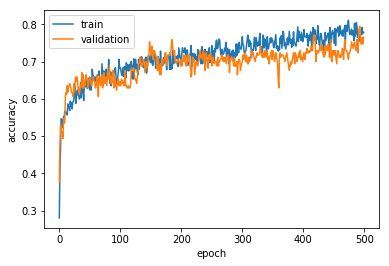

In [34]:

# list all data in history
results=np.load('Results-c10.npy').item()
# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
#plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig('c10.pdf')
plt.show()

In [4]:
print (max(results.history['acc']))
print (max(results.history['val_acc']))

0.8109305761589434
0.7941176470588235


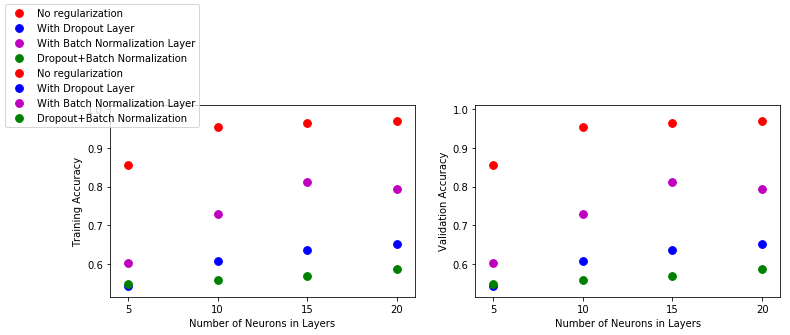

In [7]:

####scatter plot core algorithms accuracies

nodes=['5','10','15','20']
tacc00=[0.856720827,0.955686854,0.966026588,0.968980798]
tacc01=[0.542097489,0.607090104,0.636632201,0.65140325]
tacc10=[0.602658789,0.729411763,0.810930576,0.793205318]
tacc11=[0.546528804,0.556868538,0.567208272,0.586410635]
#fig = plt.figure()
#ax = fig.add_subplot(111)
f = plt.figure(figsize=(12,12))
ax = f.add_subplot(321)
#xs = ['5','5','5','5','10','10','10','10','15','15','15','15','20','20','20','20']
#ys = ['00','01','10','11','00','01','10','11','00','01','10','11','00','01','10','11']
#z=[0.856720827,0.542097489,0.602658789,0.546528804,0.955686854,0.607090104,0.729411763,0.556868538,0.966026588,0.636632201,0.810930576,0.567208272,0.968980798,0.65140325,0.793205318,0.586410635]

ax.scatter(nodes, tacc00,color='r',label='No regularization',s=60)
ax.scatter(nodes, tacc01,color='b',label='With Dropout Layer',s=60)
ax.scatter(nodes, tacc10,color='m',label='With Batch Normalization Layer',s=60 )
ax.scatter(nodes, tacc11,color='g',label='Dropout+Batch Normalization',s=60) 

#ax.ylabel('Training Accuracy')
#ax.xlabel('Number of Neurons in Layers')
ax.set_xlabel('Number of Neurons in Layers')
ax.set_ylabel('Training Accuracy')

ax2 = f.add_subplot(322)
ax2.scatter(nodes, tacc00,color='r',label='No regularization',s=60)
ax2.scatter(nodes, tacc01,color='b',label='With Dropout Layer',s=60)
ax2.scatter(nodes, tacc10,color='m',label='With Batch Normalization Layer',s=60 )
ax2.scatter(nodes, tacc11,color='g',label='Dropout+Batch Normalization',s=60) 
ax2.set_xlabel('Number of Neurons in Layers')
ax2.set_ylabel('Validation Accuracy')

f.legend(loc=2)

plt.show()

In [2]:






ys = ['00','01','10','11','00','01','10','11','00','01','10','11','00','01','10','11']
zt=[0.856720827,0.542097489,0.602658789,0.546528804,0.955686854,0.607090104,0.729411763,0.556868538,0.966026588,0.636632201,0.810930576,0.567208272,0.968980798,0.65140325,0.793205318,0.586410635]
zv=[0.764705881,0.511764706,0.529411765,0.511764706,0.805882353,0.535860104,0.685376662,0.505882353,0.847058824,0.529411765,0.794117647,0.511764706,0.829411765,0.529411765,0.758823528,0.511764706]
zr=[698.3625112,889.129374,1195.106393,1894.66461,783.4254601,820.350528,984.9361608,2107.703796,703.0714881,874.904695,1249.39178,1752.096889,661.9540679,914.8328371,1186.863098,1999.542748]
zd=[89,94,88,94,84,88,94,91,88,83,98,90,86,81,96,87]
df = pd.DataFrame()
df['X']=[0,0,0,0,1,1,1,1,2,2,2,2,3,3,3,3]
df['Y']=ys
df['Zt']=100*pd.Series(zt)
df['Zv']=100*pd.Series(zv)
df['Zr']=zr
df['Zd']=100-pd.Series(zd)


In [3]:
Zt = df['Zt']
Zv = df['Zv']
Zr = df['Zr']
Zd = df['Zd']

_, X = np.unique(df['X'], return_inverse=True)
Yuniques=['5','10','15','20']
Xuniques, Y = np.unique(df['Y'], return_inverse=True)


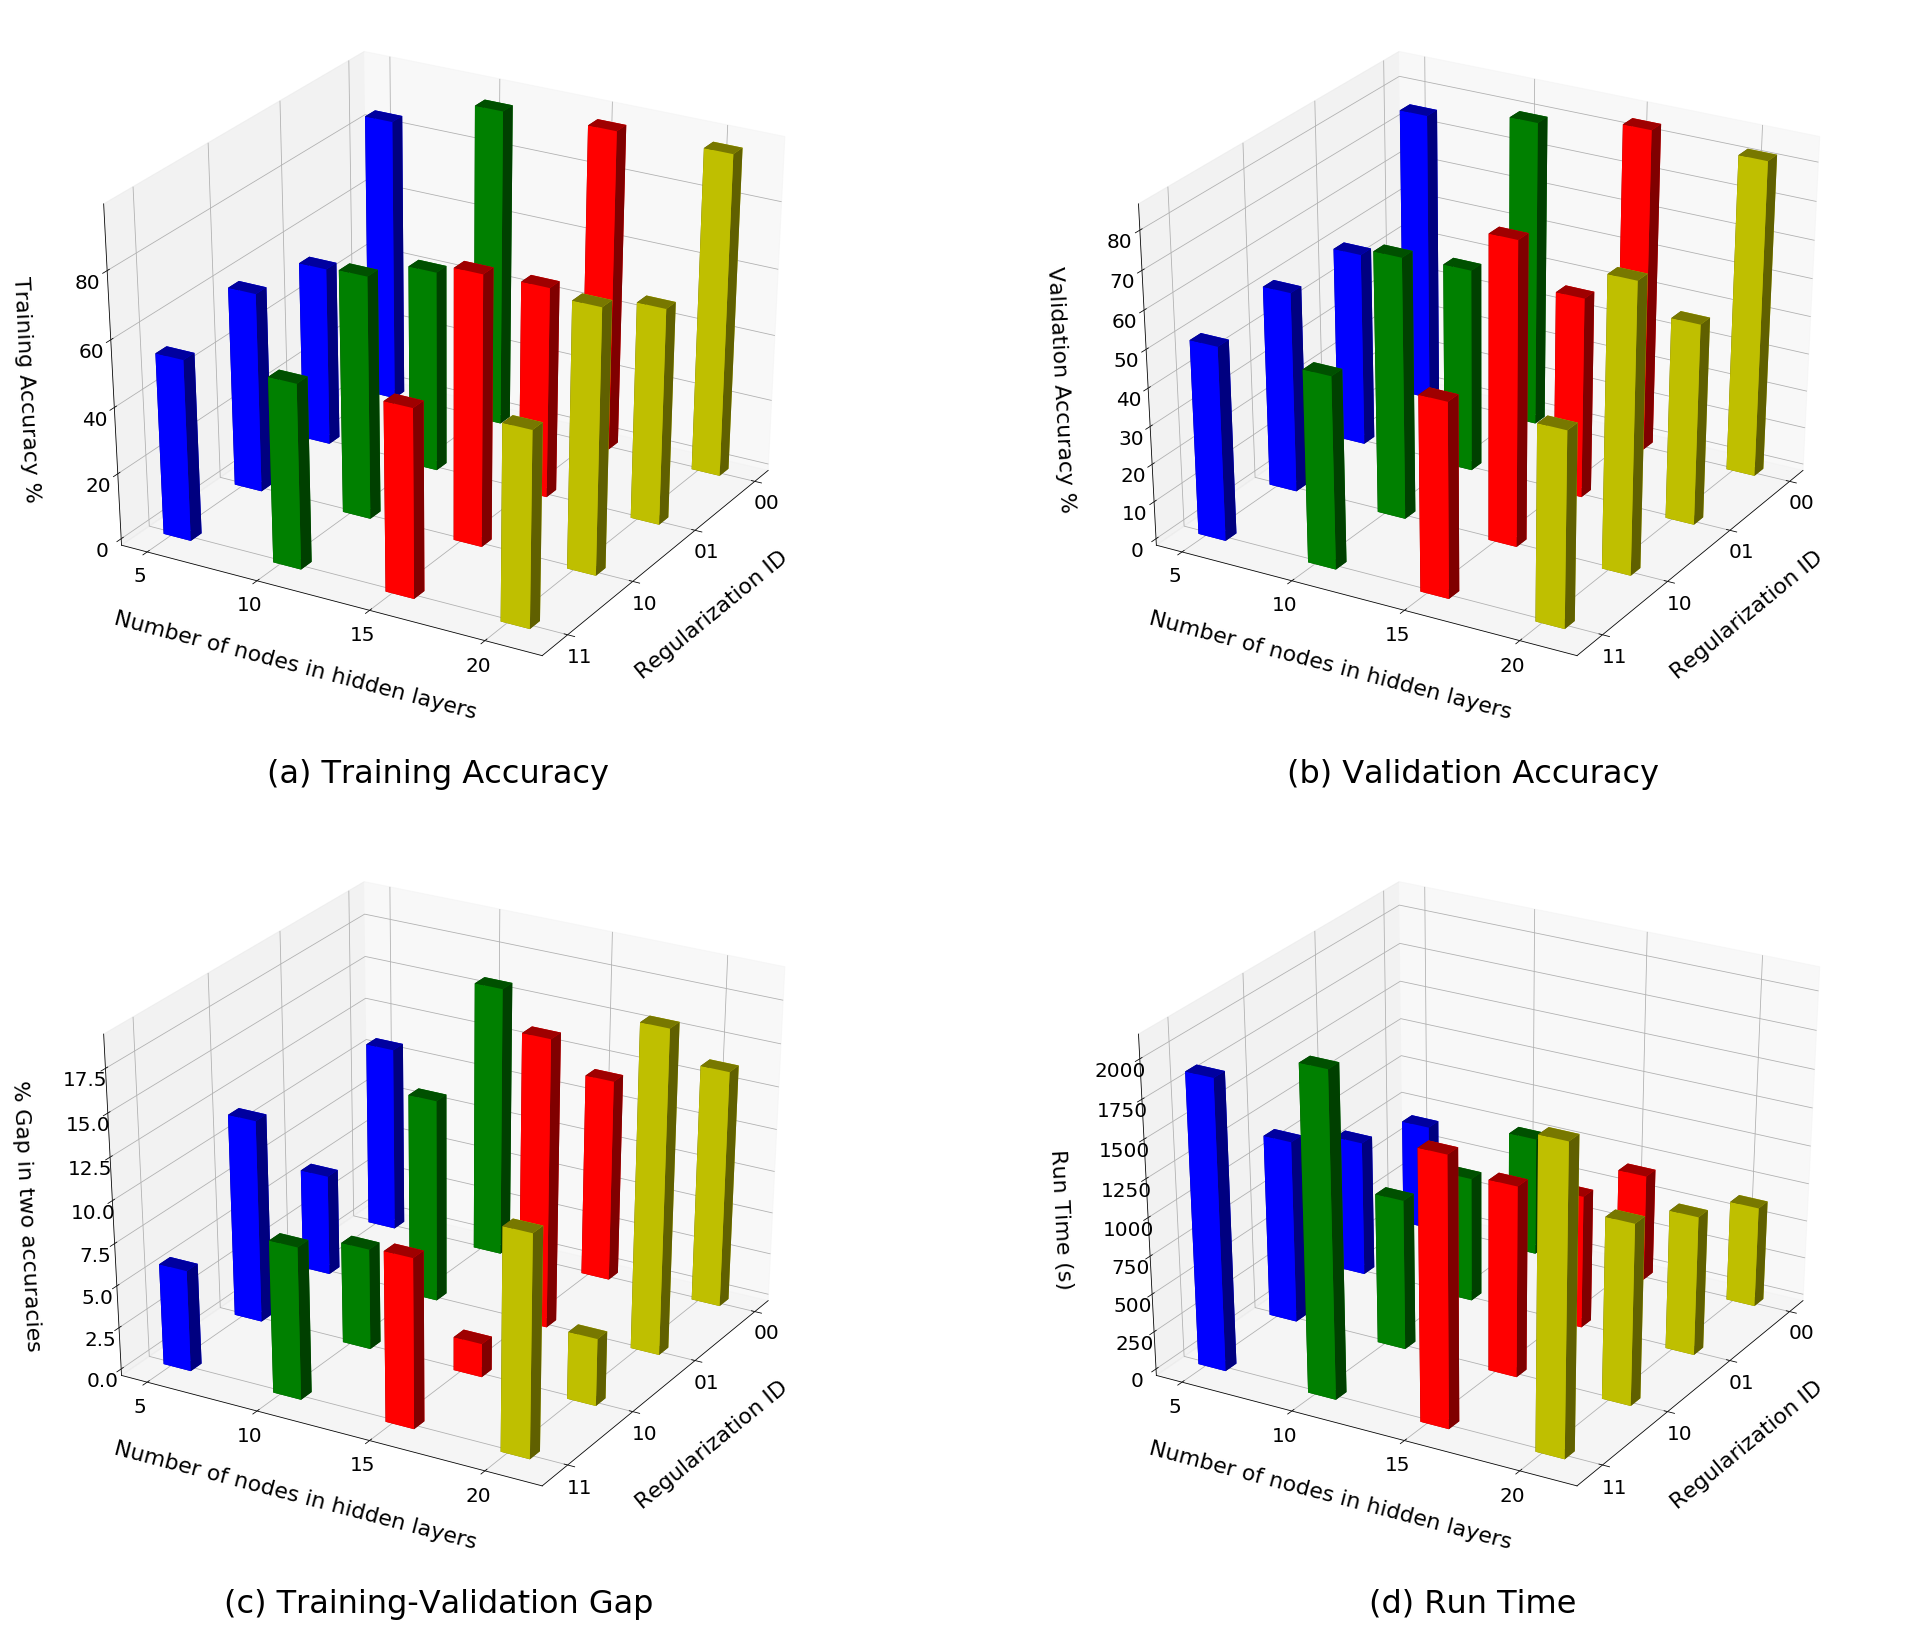

In [32]:

fig = plt.figure(figsize=(34, 28))

ax1 = fig.add_subplot(221, projection='3d')
ax2 = fig.add_subplot(222, projection='3d')
ax3 = fig.add_subplot(224, projection='3d')
ax4 = fig.add_subplot(223, projection='3d')
ax1.set_title("(a) Training Accuracy",fontsize=32,pad=-720)
ax2.set_title("(b) Validation Accuracy",fontsize=32,pad=-720)
ax3.set_title("(d) Run Time",fontsize=32,pad=-720)
ax4.set_title("(c) Training-Validation Gap",fontsize=32,pad=-720)

#training plot
top = Zt 
bottom = np.zeros_like(top)
width  = 0.15
depth = 0.25
ax1.fontsize=22
ax1.bar3d(Y[0:4], X[0:4], bottom[0:4], width, depth, top[0:4], shade=True,color='b')
ax1.bar3d(Y[4:8], X[4:8], bottom[4:8], width, depth, top[4:8], shade=True,color='g')
ax1.bar3d(Y[8:12], X[8:12], bottom[8:12], width, depth, top[8:12], shade=True,color='r')
ax1.bar3d(Y[12:16], X[12:16], bottom[12:16], width, depth, top[12:16], shade=True,color='y')
ax1.set_ylabel('Number of nodes in hidden layers',fontsize=22,labelpad=30)
ax1.set_xlabel('Regularization ID',fontsize=22,labelpad=30)
ax1.set_zlabel('Training Accuracy %',fontsize=22,labelpad=30)
ax1.tick_params(axis='both', which='major', labelsize=20)

ax1.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
       yticks=range(len(Yuniques)), yticklabels=Yuniques) 
ax1.view_init(30,30)
#validation plot
top2 = Zv 
bottom = np.zeros_like(top2)
width  = 0.15
depth = 0.25
ax2.bar3d(Y[0:4], X[0:4], bottom[0:4], width, depth, top2[0:4], shade=True,color='b')
ax2.bar3d(Y[4:8], X[4:8], bottom[4:8], width, depth, top2[4:8], shade=True,color='g')
ax2.bar3d(Y[8:12], X[8:12], bottom[8:12], width, depth, top2[8:12], shade=True,color='r')
ax2.bar3d(Y[12:16], X[12:16], bottom[12:16], width, depth, top2[12:16], shade=True,color='y')
ax2.set_ylabel('Number of nodes in hidden layers',fontsize=22,labelpad=30)
ax2.set_xlabel('Regularization ID',fontsize=22,labelpad=30)
ax2.set_zlabel('Validation Accuracy %',fontsize=22,labelpad=30)
ax2.tick_params(axis='both', which='major', labelsize=20)

ax2.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
       yticks=range(len(Yuniques)), yticklabels=Yuniques) 
ax2.view_init(30,30)

#runtime plot
top = Zr 
bottom = np.zeros_like(top)
width  = 0.15
depth = 0.25
ax3.bar3d(Y[0:4], X[0:4], bottom[0:4], width, depth, top[0:4], shade=True,color='b')
ax3.bar3d(Y[4:8], X[4:8], bottom[4:8], width, depth, top[4:8], shade=True,color='g')
ax3.bar3d(Y[8:12], X[8:12], bottom[8:12], width, depth, top[8:12], shade=True,color='r')
ax3.bar3d(Y[12:16], X[12:16], bottom[12:16], width, depth, top[12:16], shade=True,color='y')
ax3.set_ylabel('Number of nodes in hidden layers',fontsize=22,labelpad=30)
ax3.set_xlabel('Regularization ID',fontsize=22,labelpad=30)
ax3.set_zlabel('Run Time (s)',fontsize=22,labelpad=30)
ax3.tick_params(axis='both', which='major', labelsize=20)

ax3.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
       yticks=range(len(Yuniques)), yticklabels=Yuniques) 
ax3.view_init(30,30)
#runtime plot
top = Zd 
bottom = np.zeros_like(top)
width  = 0.15
depth = 0.25
ax4.bar3d(Y[0:4], X[0:4], bottom[0:4], width, depth, top[0:4], shade=True,color='b')
ax4.bar3d(Y[4:8], X[4:8], bottom[4:8], width, depth, top[4:8], shade=True,color='g')
ax4.bar3d(Y[8:12], X[8:12], bottom[8:12], width, depth, top[8:12], shade=True,color='r')
ax4.bar3d(Y[12:16], X[12:16], bottom[12:16], width, depth, top[12:16], shade=True,color='y')
ax4.set_ylabel('Number of nodes in hidden layers',fontsize=22,labelpad=30)
ax4.set_xlabel('Regularization ID',fontsize=22,labelpad=30)
ax4.set_zlabel('% Gap in two accuracies ',fontsize=22,labelpad=30)
ax4.tick_params(axis='both', which='major', labelsize=20)

ax4.set(xticks=range(len(Xuniques)), xticklabels=Xuniques,
       yticks=range(len(Yuniques)), yticklabels=Yuniques,) 
ax4.view_init(30,30)

plt.savefig('conf.pdf')

plt.show()


In [ ]:
features=X_train.columns[0:]
target='Mode'

# Pseduo ResNet MLP Grid search
from pseudoMLPResNet import Unit, MiniModel,PseudoLabeler

############## set params here:
nepoch=10   #number of epochs
nbatchsize=32       #batchsize
num_folds = 10        
sample_rates = [0]
hUs = [3]   #number of units, number of total layers would be hu*2+2



model=PseudoLabeler(KerasClassifier(build_fn=MiniModel, epochs=nepoch, batch_size=nbatchsize, verbose=0),
                    X_test, features, target)

c, r = y_train.shape
y_train = y_train.values.reshape(c,)
X_train = X_train.values.reshape(c,15)
param_grid = dict(hU=hUs, sample_rate=sample_rates)


t0 = time.time()
if __name__=='__main__':
    grid = GridSearchCV(estimator=model, param_grid=param_grid,scoring='accuracy',cv=num_folds,verbose=10,n_jobs=-1)
    grid_result = grid.fit(X_train, y_train)
    

np.save('GridResults2.npy',grid_result.cv_results_)
t1 = time.time()  
totalsem=t1-t0

In [ ]:
# summarize results
GridResults=np.load('GridResults2.npy').item()
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))



In [ ]:
# Mac load data py2
GridResults=np.load('GridResults.npy').item()
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = GridResults['mean_test_score']
stds = GridResults['std_test_score']
params = GridResults['params']
for mean, stdev, param in zip(means, stds, params):
	print("%f (%f) with: %r" % (mean, stdev, param))



In [ ]:
#### RESNET-MLP
niter=2
nepoch=10
nbatchsize=32
num_folds = 2
iter = np.linspace(1, niter, niter)
model=KerasClassifier(build_fn=MiniModel, epochs=nepoch, batch_size=nbatchsize, verbose=0)

    
results = {}
results['ResNet20'] = list()

t0 = time.time()    
if __name__=='__main__':

    for i in iter:
            model.seed = i
            
            scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=num_folds,n_jobs=-1)
            
            results['ResNet20'].append(scores.mean())
    


t1 = time.time()
total = t1-t0
average_acc=sum(results['ResNet20'])/niter

In [ ]:
# plotting-not updated yet
import matplotlib.pyplot as plt

compare=plt.figure(figsize=(16, 18))

i = 1
for model_name, performance in results.items():    
    plt.subplot(3, 3, i)
    i += 1
    
    plt.plot(sample_rates, performance)
    plt.title(model_name)
    plt.xlabel('sample_rate')
    plt.ylabel('Accuracy')
    

plt.show()
compare.savefig("foo.pdf", bbox_inches='tight')

In [ ]:
#confusion matrix, not implemented yet
model=pseudo_label_wrapper(RandomForestClassifier(n_estimators=400, max_depth=None,min_samples_split=2, random_state=0))
model.sample_rate=0.6
y_pred = cross_val_predict(model, X_train, y_train, cv=10)
conf_mat = confusion_matrix(y_train, y_pred)
conf_mat_norm=conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]

In [ ]:
\